In [1]:
import numpy as np
import emoji
from emo_utils import *
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
maxLen = len(max(X_train, key=len).split())

In [4]:
def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)])

In [5]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again :disappointed:
I am proud of your achievements :smile:
It is the worst day in my life :disappointed:
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit :disappointed:
congratulations on your acceptance :smile:
The assignment is too long  :disappointed:
I want to go play ⚾


In [6]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [10]:
idx = 15
print(f"Sentence '{X_train[15]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'Stop shouting at me' has label index 3, which is emoji :disappointed:
Label index 3 in one-hot encoding format is [0. 0. 0. 1. 0.]


In [14]:
words = set()
word_to_vec_map = {}
f = open('data/glove.6B.50d.txt', encoding='utf-8')
for line in f:
  line = line.strip().split()
  curr_word = line[0]
  words.add(curr_word)
  word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

i = 1
words_to_index = {}
index_to_words = {}
for w in sorted(words):
    words_to_index[w] = i
    index_to_words[i] = w
    i = i + 1
f.close()

In [16]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", words_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_words[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [19]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split()

    avg = np.zeros(word_to_vec_map[any_word].shape)
    count = 0

    for word in words:
      if word in list(word_to_vec_map.keys()):
        avg += word_to_vec_map[word]
        # Increment count
        count +=1
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg/count

    return avg

In [20]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

def sentence_to_avg_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    avg = target("a a_nw c_w a_s", word_to_vec_map)
    assert tuple(avg.shape) == tuple(word_to_vec_map['a'].shape),  "Check the shape of your avg array"  
    assert np.allclose(avg, [1.25, 2.5]),  "Check that you are finding the 4 words"
    avg = target("love a a_nw c_w a_s", word_to_vec_map)
    assert np.allclose(avg, [1.25, 2.5]), "Divide by count, not len(words)"
    avg = target("love", word_to_vec_map)
    assert np.allclose(avg, [0, 0]), "Average of no words must give an array of zeros"
    avg = target("c_se foo a a_nw c_w a_s deeplearning c_nw", word_to_vec_map)
    assert np.allclose(avg, [0.1666667, 2.0]), "Debug the last example"
    
    print("\033[92mAll tests passed!")
    
sentence_to_avg_test(sentence_to_avg)

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
All tests passed!


In [28]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 20):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Initialize cost. It is needed during grading
    cost = 0
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
          avg = sentence_to_avg(X[i], word_to_vec_map)
          z = np.dot(W, avg) + b
          a = softmax(z)
          cost = -np.sum(np.dot(Y_oh[i], np.log(a)))

          dz = a - Y_oh[i]
          dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
          db = dz

          W = W - learning_rate * dW
          b = b - learning_rate * db
        if t % 10 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py
    return pred, W, b

In [22]:
def model_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    # Training set. Sentences composed of a_* words will be of class 0 and sentences composed of c_* words will be of class 1
    X = np.asarray(['a a_s synonym_of_a a_n c_sw', 'a a_s a_n c_sw', 'a_s  a a_n', 'synonym_of_a a a_s a_n c_sw', " a_s a_n",
                    " a a_s a_n c ", " a_n  a c c c_e",
                   'c c_nw c_n c c_ne', 'c_e c c_se c_s', 'c_nw c a_s c_e c_e', 'c_e a_nw c_sw', 'c_sw c c_ne c_ne'])
    
    Y = np.asarray([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    
    np.random.seed(10)
    pred, W, b = model(X, Y, word_to_vec_map, 0.0025, 110)
    
    assert W.shape == (2, 2), "W must be of shape 2 x 2"
    assert np.allclose(pred.transpose(), Y), "Model must give a perfect accuracy"
    assert np.allclose(b[0], -1 * b[1]), "b should be symmetric in this example"
    
    print("\033[92mAll tests passed!")
    
model_test(model)

Epoch: 0 --- cost = 0.05105772513207823
Accuracy: 0.9166666666666666
Epoch: 10 --- cost = 0.03893716809550303
Accuracy: 0.9166666666666666
Epoch: 20 --- cost = 0.03078199487865477
Accuracy: 0.9166666666666666
Epoch: 30 --- cost = 0.0250625254818359
Accuracy: 0.9166666666666666
Epoch: 40 --- cost = 0.020906296817970453
Accuracy: 0.9166666666666666
Epoch: 50 --- cost = 0.017791876552201644
Accuracy: 0.9166666666666666
Epoch: 60 --- cost = 0.015394747683241103
Accuracy: 0.9166666666666666
Epoch: 70 --- cost = 0.01350575460904451
Accuracy: 1.0
Epoch: 80 --- cost = 0.01198593465621373
Accuracy: 1.0
Epoch: 90 --- cost = 0.01074046826626526
Accuracy: 1.0
Epoch: 100 --- cost = 0.00970311068897676
Accuracy: 1.0
All tests passed!


In [23]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5, 0, 0, 5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and have drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is surprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


In [29]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.9520498812810072
Accuracy: 0.3484848484848485
Epoch: 10 --- cost = 1.0040987758894053
Accuracy: 0.7272727272727273
[[3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [0.]
 [3.]
 [2.]
 [1.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [3.]
 [1.]
 [4.]
 [3.]
 [0.]
 [2.]
 [2.]
 [4.]
 [1.]
 [3.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [3.]
 [3.]
 [2.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [3.]
 [3.]
 [0.]
 [2.]
 [2.]
 [4.]
 [3.]
 [2.]
 [4.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [0.]
 [1.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [3.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [1.]
 [0.]
 [4.]
 [1.]
 [1.]
 [2.]
 [3.]
 [4.]
 [3.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]
 [0.]
 [4.]
 [2.]
 [3.]
 [3.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [0.]
 [2.]]


In [30]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.803030303030303
Test set:
Accuracy: 0.7321428571428571


In [31]:
def predict_single(sentence, W=W, b=b, word_to_vec_map=word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """

    any_word = list(word_to_vec_map.keys())[0]
    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0] 
        
    # Split jth test example (sentence) into list of lower case words
    words = sentence.lower().split()

    # Average words' vectors
    avg = np.zeros((n_h,))
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count += 1

    if count > 0:
        avg = avg / count

    # Forward propagation
    Z = np.dot(W, avg) + b
    A = softmax(Z)
    pred = np.argmax(A)
        
    
    return pred

In [34]:
label_to_emoji(int(predict_single("He is amazing")))

':smile:'

(56,)
           ❤️    ⚾    :smile:    :disappointed:   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            4    1    0    2    0    7
1            0    8    0    0    0    8
2            2    0   14    2    0   18
3            2    0    3   11    0   16
4            0    0    1    2    4    7
All          8    9   18   17    4   56


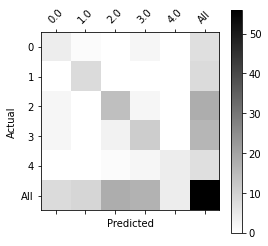

In [35]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)